In [1]:
import os
os.chdir('mmsegmentation')

In [2]:
os.getcwd()

'/home/featurize/mmsegmentation'

In [3]:
import os
import numpy as np
import cv2
from tqdm import tqdm

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# 模型 config 配置文件
config_file = 'Zihao-Configs/ZihaoDataset_KNet_20230818.py'

# 模型 checkpoint 权重文件
checkpoint_file = 'checkpoint/Zihao_KNet.pth'

# 计算硬件
# device = 'cpu'
device = 'cuda:0'

In [5]:
model = init_model(config_file, checkpoint_file, device=device)

/home/featurize/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/featurize/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


Loads checkpoint by local backend from path: checkpoint/Zihao_KNet.pth


In [6]:
# 每个类别的 BGR 配色
palette = [
    ['background', [127,127,127]],
    ['ketin', [163,196,63]],
    ['woshi', [63,204,65]],
    ['weishengjian', [76,49,102]],
    ['chufang', [89,56,32]],
    ['yangtai', [57,112,159]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [7]:
palette_dict

{0: [127, 127, 127],
 1: [163, 196, 63],
 2: [63, 204, 65],
 3: [76, 49, 102],
 4: [89, 56, 32],
 5: [57, 112, 159]}

In [8]:
# if not os.path.exists('outputs/testset-pred'):
#     os.mkdir('outputs/testset-pred')

In [41]:
PATH_IMAGE = '/home/featurize/mmsegmentation/labelme2marsk/img_dir/val'

In [42]:
os.chdir(PATH_IMAGE)

In [43]:
opacity = 0 # 透明度，越大越接近原图

In [44]:
def process_single_img(img_path, save=False):
    
    img_bgr = cv2.imread(img_path)

    # 语义分割预测
    result = inference_model(model, img_bgr)
    pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')

    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(img_bgr, opacity, pred_mask_bgr, 1-opacity, 0)
    
    # 保存图像至 outputs/testset-pred 目录
    if save:
        save_path = os.path.join('../','../','../','outputs', 'testset-pred', 'pred-'+img_path.split('/')[-1])
        cv2.imwrite(save_path, pred_viz)

In [45]:
for each in tqdm(os.listdir()):
    process_single_img(each, save=True)

100%|██████████| 439/439 [02:16<00:00,  3.21it/s]


In [36]:
os.chdir(os.path.join('../','../','../'))

In [37]:
os.chdir('outputs/testset-pred')

TypeError: 'NoneType' object is not subscriptable

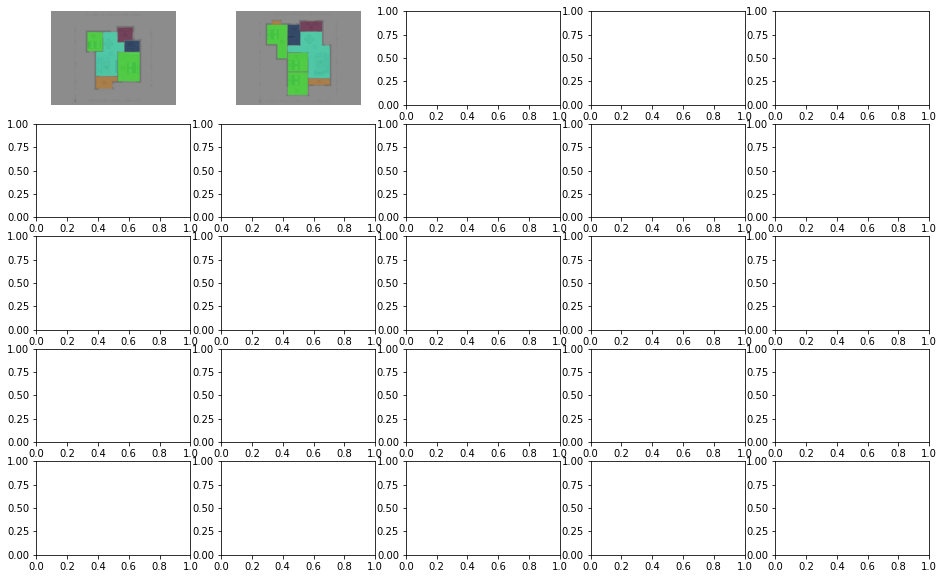

In [38]:
# n 行 n 列可视化
n = 5

fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(16, 10))

for i, file_name in enumerate(os.listdir()[:n**2]):
    
    img_bgr = cv2.imread(file_name)
    
    # 可视化
    axes[i//n, i%n].imshow(img_bgr[:,:,::-1])
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Semantic Segmentation Predictions', fontsize=30)
# plt.tight_layout()
plt.savefig('../K3.jpg')
plt.show()